In [11]:
from sklearn.model_selection import train_test_split
from glob import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

Using TensorFlow backend.


# Keras and Transfer Learning

This notebook focuses on re-using a previously trained artificial neural network to classify pictures of cats and dogs. We first download, unpack and copy all the needed data:

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

In [6]:
!mkdir ./data/cats_dogs
!mv PetImages ./data/cats_dogs/train

mkdir: cannot create directory ‘./data/cats_dogs’: File exists


In [7]:
cats = glob('data/cats_dogs/train/Cat/*.jpg')
dogs = glob('data/cats_dogs/train/Dog/*.jpg')

cats_train, cats_test = train_test_split(cats, test_size=0.30)
dogs_train, dogs_test = train_test_split(dogs, test_size=0.30)

TRAIN_DIR = 'data/cats_dogs/train'
TEST_DIR = 'data/cats_dogs/test'

!mkdir data/cats_dogs/test

!mkdir data/cats_dogs/test/Cat
files = ' '.join(cats_test)
!mv -t data/cats_dogs/test/Cat $files

!mkdir data/cats_dogs/test/Dog
files = ' '.join(dogs_test)
!mv -t data/cats_dogs/test/Dog $files

In [8]:
%ls data/cats_dogs

test/  train/


Plot some images:

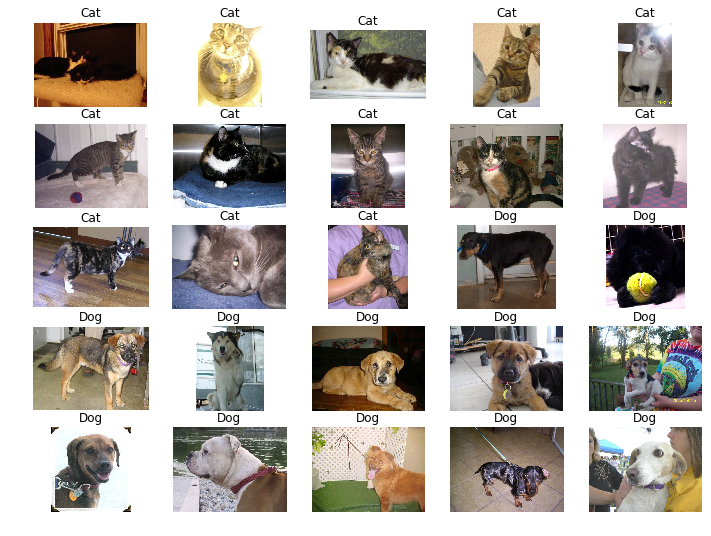

In [12]:
cats = np.random.choice(cats_train, 13)
dogs = np.random.choice(dogs_train, 12)
data = np.concatenate((cats, dogs))
labels = 13 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Model Customization

Here we use InceptionV3 ANN and download its weights. The InceptionV3 has the following architecture:

![](https://cdn-images-1.medium.com/max/2400/0*te3xksOrVytM-B17)

In [13]:
CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87916544/87910968 [==============================] - 32s 0us/step


## Data Augmentation

In [14]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [15]:
x,y = next(train_generator)
x.shape,y.shape

((32, 299, 299, 3), (32, 2))

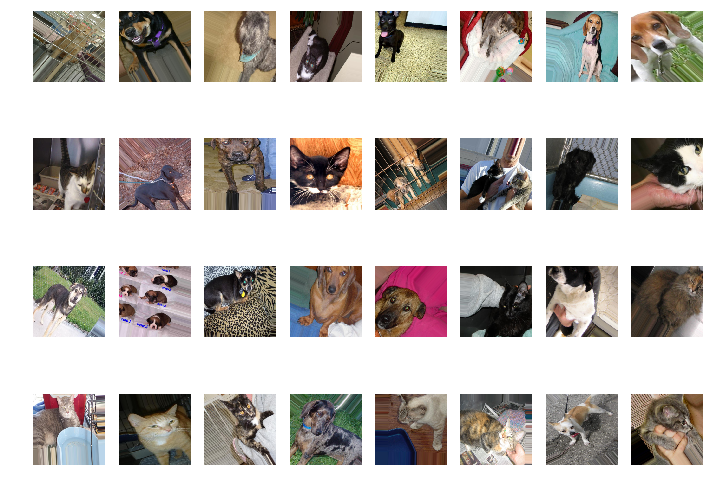

In [16]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [9]:
EPOCHS = 1
BATCH_SIZE = 2
STEPS_PER_EPOCH = 32
VALIDATION_STEPS = 16

MODEL_FILE = 'filename.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/1
32/32 [==============================] - 563s 18s/step - loss: 0.3361 - acc: 0.8613 - val_loss: 0.4605 - val_acc: 0.7617


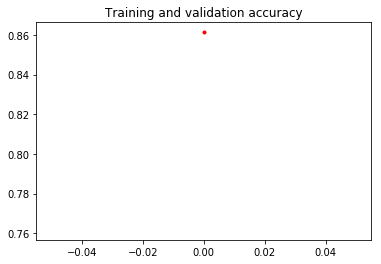

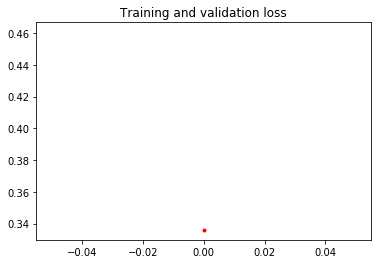

In [10]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
  
plot_training(history)

## Prediction of the Custom Model

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("cat", "dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [13]:
from keras.models import load_model
MODEL_FILE = 'filename.model'
model = load_model(MODEL_FILE)

In [18]:
%ls data/cats_dogs/test/Dog/ | head

0.jpg
10000.jpg
10002.jpg
10004.jpg
10010.jpg
10011.jpg
10012.jpg
10013.jpg
10014.jpg
10016.jpg
ls: write error


array([0.3933948 , 0.60660523], dtype=float32)

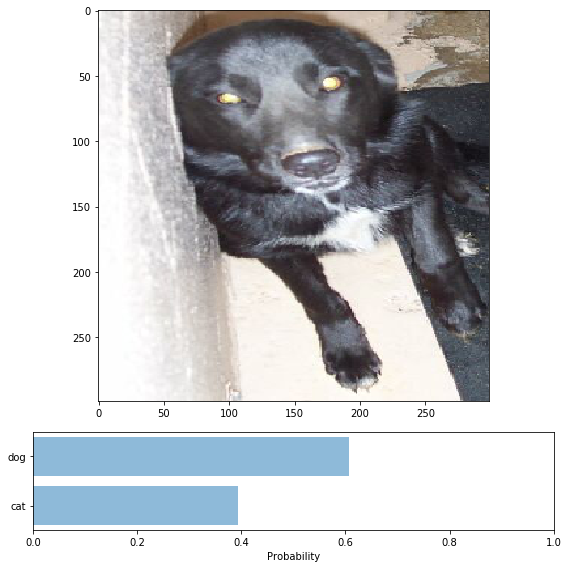

In [19]:
img = image.load_img('data/cats_dogs/test/Dog/10000.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds

array([0.9795893 , 0.02041066], dtype=float32)

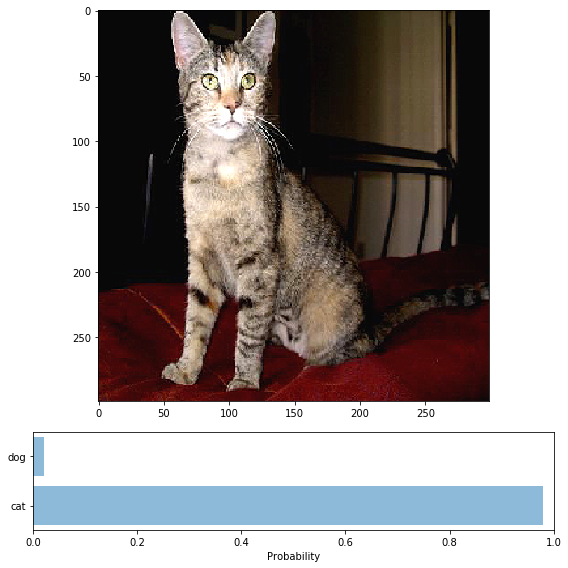

In [20]:
img = image.load_img('data/cats_dogs/test/Cat/10000.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds